Objective: Develop a multiclass classifier using the entire MNIST data set for input data. The classifier will be used to predict which of 10 digits is being written.

In [ ]:
# https://www.kaggle.com/c/digit-recognizer/data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. 

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

Assignment steps:

(1) Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model training set (train.csv). Record the time it takes to fit the model and then evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

(2) Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components.

(3) Using the identified principal components from step (2), use the train.csv to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

(4) Submit both the RF Classifier and the PCA RF Classifier to Kaggle.com, and report both scores along with your user name.  I MUST have your user name to verify submission status.

Report total elapsed time measures for the training set analysis.  It is sufficient to run a single time-elapsed test for this assignment.

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import os
import random
import time

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Visualizations
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
%matplotlib inline

In [2]:
# Initialize process time list for code timing across entire program
process_time = []

# Import and inspect training data

In [3]:
# Import train and test datasets

# The training data set, (train.csv), has 785 columns. The first column, called "label", is the 
# digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# 42,000 images
# Each image has 784 features (each image is 28 x 28 pixels) and 1 label feature (785 total)
# Each feature represents one pixel's intensity from 0 (white) to 255 (black)
train.shape

(42000, 785)

In [5]:
# 28,000 images, contains 784 features and no label
test.shape

(28000, 784)

In [6]:
# Inspect class balances for train set, seems relatively balanced
print(train['label'].value_counts(ascending=False))
print('--------------------')
print(train['label'].value_counts(normalize=True))

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64
--------------------
1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64


**Figure 1: Label Distribution in Train Set**

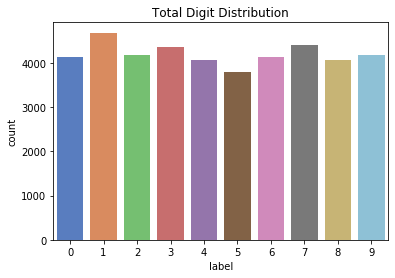

In [51]:
# Plot label distribution from Kaggle train set
mn_plot_total = sns.countplot(train['label'], palette="muted").set_title('Total Digit Distribution')

In [7]:
# Save the labels to a Pandas series target
y = train['label']

# Drop the label feature
X = train.drop("label",axis=1)

In [8]:
# Confirm that all 256 values between the min-max of 0-255 exist in the train set
len(np.unique(X))

256

In [13]:
# View images
images_to_plot = 9
random_indices = random.sample(range(42000), images_to_plot)

sample_images = X.loc[random_indices, :]
sample_labels = y.loc[random_indices]

<Figure size 432x288 with 0 Axes>

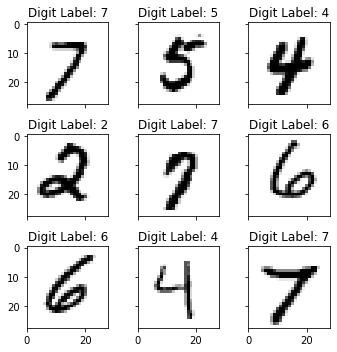

In [14]:
# Plot examples
plt.clf()
plt.style.use('seaborn-muted')

fig, axes = plt.subplots(3,3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(adjustable='box', aspect='equal')) #https://stackoverflow.com/q/44703433/1870832

for i in range(images_to_plot):
    
    # axes (subplot) objects are stored in 2d array, accessed with axes[row,col]
    subplot_row = i//3 
    subplot_col = i%3  
    ax = axes[subplot_row, subplot_col]

    # plot image on subplot
    plottable_image = np.reshape(sample_images.iloc[i,:].values, (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_title('Digit Label: {}'.format(sample_labels.iloc[i]))
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()

# Step 1: Fit a Random Forest classifier and evaluate on test set
- OOB model
- Train and evaluate
- Grid search
- Train and evaluate
- Predict
- Confusion matrix

### 1. Train test split and distribution of labels

In [9]:
# Assign classifier
# Use default criterion (gini)
cls_rf = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=90)

In [10]:
# Split train and test set 90/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)

In [11]:
# Check split
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


**Figure 2: Label Distribution in Training Set**

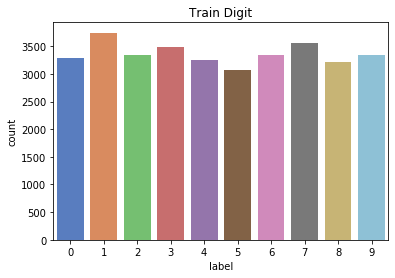

In [32]:
# Evaluate distribution of labels across train set
mn_plt_trn = sns.countplot(y_train, palette="muted").set_title('Train Digit')

**Figure 3: Label Distribution in Test Set**

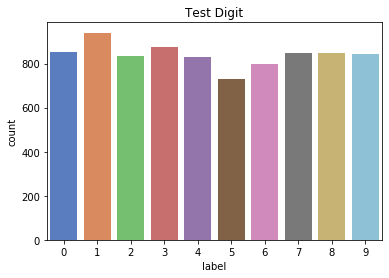

In [33]:
# Evaluate distribution of labels across test set
mn_plt_tst = sns.countplot(y_test, palette="muted").set_title('Test Digit')

### 2. Initial classification with Random Forest

In [12]:
# Fit model and run on test set with timing
start_time = time.time()
cls_rf.fit(X_train, y_train)
print('Accuracy: ', cls_rf.score(X_test, y_test))

# Timing
elapsed_time = time.time() - start_time
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Time in seconds: ', elapsed_time)
process_time.append(elapsed_time)

Accuracy:  0.9655952380952381
Formatted time:  00:00:07
Time in seconds:  7.7275731563568115


### 3. Grid search for fine-tuning
Try n_estimator hyperparameter

In [36]:
# cls_rf = RandomForestClassifier()

param_grid = {
    'bootstrap': [True],
    'max_depth': range(2,10),
    'n_estimators': [100,150,200,250,300,400,500]
}

grid_search_rf = GridSearchCV(estimator=cls_rf, param_grid=param_grid, cv=3, 
                              return_train_score=True, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=90, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                     

In [37]:
# Display parameter recommendations
print('Test set score: ', grid_search_rf.score(X_test, y_test))
print('Best parameters: ', grid_search_rf.best_params_)
print('Best cross-validation score: ', grid_search_rf.best_score_)

Test set score:  0.9342857142857143
Best parameters:  {'bootstrap': True, 'max_depth': 9, 'n_estimators': 300}
Best cross-validation score:  0.9366666666666666


In [13]:
# Adjust model parameters, not using max depth
cls_rf = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=300)

# Original
# cls_rf = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=90)

In [14]:
# Fit the tuned parameters with timing
start_time = time.time()
cls_rf.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Results with tuning
print('Accuracy: ', cls_rf.score(X_test, y_test))

# Timing
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Time in seconds: ', elapsed_time)
process_time.append(elapsed_time)

Accuracy:  0.9667857142857142
Formatted time:  00:00:23
Time in seconds:  23.325534105300903


In [15]:
# F1 score
pred = cls_rf.predict(X_test)
print('F1 accuracy: ', f1_score(pred, y_test, average='macro'))

F1 accuracy:  0.9665596424569133


In [16]:
# Print classification report
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7',
                   'class 8', 'class 9']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99       853
     class 1       0.99      0.98      0.98       940
     class 2       0.96      0.97      0.97       835
     class 3       0.97      0.94      0.95       873
     class 4       0.96      0.97      0.96       829
     class 5       0.96      0.96      0.96       731
     class 6       0.98      0.98      0.98       800
     class 7       0.97      0.96      0.97       850
     class 8       0.96      0.96      0.96       846
     class 9       0.95      0.94      0.94       843

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



### 3. Confusion matrix

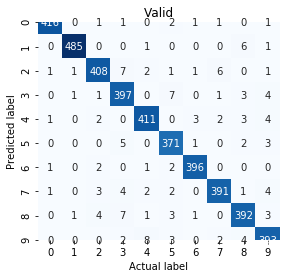

In [49]:
# Plot confusion matrix of actual versus predicted labels
rf_cm = confusion_matrix(y_test, pred)
rf_cm_plt=sns.heatmap(rf_cm.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
plt.title("Valid");

### 4. Evaluate model on test set for Kaggle

In [17]:
# Submission code
testData = pd.read_csv("test.csv")
start_time = time.time()
pred = cls_rf.predict(testData)
elapsed_time = time.time() - start_time
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Time in seconds: ', elapsed_time)
process_time.append(elapsed_time)

# Create Dataframe
data = pred
df_1 = pd.DataFrame(pred)
df_1['ImageID'] = df_1.index + 1
df_1.columns = ['Label', 'ImageID']
submission = df_1[['ImageID', 'Label']]

# Output to csv
submission.to_csv('Boetticher_RF_predictions_8020.csv',header=True, index=False)

Formatted time:  00:00:01
Time in seconds:  1.1097159385681152


**Kaggle ID: Claire Boetticher**<br>
**Kaggle username: clairence**

<img src = "RF8020.png">

# Step 2: Principal Components Analysis

### 1. Data preparation and PC identification

In [18]:
# Combine training and test set for PCA
x = np.concatenate((X_train, X_test), axis=0)

In [19]:
# Fit model using PCA, generating principal components that represent 95 percent of the variability in 
# the explanatory features
start_time = time.time()
pca = PCA(.95)
pca.fit(x)
totimages = pca.transform(x)
# pca.n_components_

# Timing
elapsed_time = time.time() - start_time
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Time in seconds: ', elapsed_time)
process_time.append(elapsed_time)

Formatted time:  00:00:05
Time in seconds:  5.606950998306274


In [20]:
# Output number of principal components explaining 95% of variability in the explanatory features: 154
print('Principal components count: ', pca.n_components_)

Principal components count:  154


### 2. Explained variance ratio and visualization

In [21]:
# Explained variance ratio for 154 PCs
# 10% of the train dataset's variance lies along the first PC
# 7% along the second
# 6% along the third, etc.
pca.explained_variance_ratio_

array([0.09748938, 0.07160266, 0.06145903, 0.05379302, 0.04894262,
       0.04303214, 0.03277051, 0.02892103, 0.02766902, 0.02348871,
       0.02099325, 0.02059001, 0.01702553, 0.01692787, 0.01581126,
       0.0148324 , 0.01319688, 0.01282727, 0.01187976, 0.01152755,
       0.01072191, 0.01015199, 0.00964902, 0.00912846, 0.00887641,
       0.00838766, 0.00811856, 0.00777406, 0.00740635, 0.00686661,
       0.00657982, 0.00638799, 0.00599367, 0.00588913, 0.00564335,
       0.00540967, 0.00509222, 0.00487505, 0.00475569, 0.00466545,
       0.00452952, 0.00444989, 0.00418255, 0.00397506, 0.00384542,
       0.00374919, 0.00361013, 0.00348522, 0.00336488, 0.00320738,
       0.00315467, 0.00309146, 0.00293709, 0.00286541, 0.00280759,
       0.00269618, 0.00265831, 0.00256299, 0.00253821, 0.00246178,
       0.00239716, 0.0023874 , 0.00227591, 0.00221518, 0.00213934,
       0.00206133, 0.00202851, 0.00195977, 0.00193639, 0.00188485,
       0.00186751, 0.0018167 , 0.00176891, 0.00172592, 0.00166

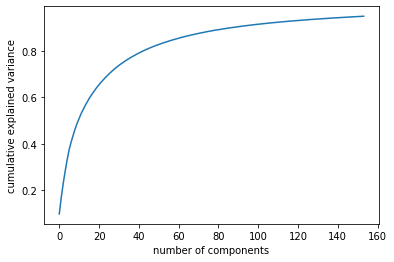

In [22]:
#Explained variance plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [22]:
# Reform the training and testing images
# Training: up to 33,600
# Testing: 33,600 to 42,000
trainimages = totimages[0:33600, :]
testimages = totimages[33600:42000, :]

In [23]:
# Convert to integers
trainimages = trainimages.astype(int)
testimages = testimages.astype(int)

### 3. Test Incremental PCA

In [24]:
# Time component identification
start_time = time.time()

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

# Timing
elapsed_time = time.time() - start_time
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Time in seconds: ', elapsed_time)
process_time.append(elapsed_time)

Formatted time:  00:00:08
Time in seconds:  8.207072019577026


In [32]:
# Explained variance ratio for 154 PCs with incremental PCA
# 10% of the train dataset's variance lies along the first PC
# 7% along the second
# 6% along the third, etc.
# Not drastically different than PCA and took longer
inc_pca.explained_variance_ratio_

array([0.0974987 , 0.07141142, 0.06151824, 0.05388163, 0.04890098,
       0.04318881, 0.03282591, 0.02884297, 0.0276572 , 0.02350486,
       0.02100847, 0.02057254, 0.0170844 , 0.01697231, 0.01571694,
       0.01481204, 0.01322833, 0.01281248, 0.01185411, 0.0115275 ,
       0.01073516, 0.01014294, 0.00964169, 0.00912906, 0.00885071,
       0.00839414, 0.00812626, 0.00777431, 0.00738998, 0.00686648,
       0.00657795, 0.00636188, 0.00599267, 0.00587324, 0.00562946,
       0.00542793, 0.00508767, 0.00489156, 0.00474121, 0.00466481,
       0.00454451, 0.00446174, 0.00417216, 0.00396312, 0.00385106,
       0.00375317, 0.00362015, 0.00348357, 0.00336826, 0.00320721,
       0.00315766, 0.00308749, 0.00292497, 0.00286046, 0.00281125,
       0.00268951, 0.00265246, 0.00257036, 0.0025385 , 0.00244912,
       0.00240386, 0.00238819, 0.00227269, 0.00220696, 0.00213842,
       0.00207173, 0.00202547, 0.00195977, 0.00193556, 0.00188451,
       0.00186966, 0.00181152, 0.00176677, 0.00172303, 0.00166

# Step 3: Random Forest Classifier with Principal Components

### 1. Fit model with principal components

In [30]:
# Fit the model
start_time = time.time()
cls_rf2 = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=300)
cls_rf2.fit(trainimages, y_train)
elapsed_time = time.time() - start_time
print('Accuracy: ', cls_rf2.score(testimages, y_test))

# Timing
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Time in seconds: ', elapsed_time)
process_time.append(elapsed_time)

Accuracy:  0.9448809523809524
Formatted time:  00:00:32
Time in seconds:  32.40455889701843


In [31]:
# Predict a second time with principal components
pred2 = cls_rf2.predict(testimages)
print('F1 accuracy: ', f1_score(pred2, y_test, average='macro'))

F1 accuracy:  0.9444212610466947


### 2. Confusion matrix

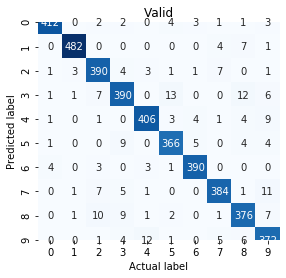

In [50]:
# Plot confusion matrix of actual versus predicted labels
rf_cm = confusion_matrix(y_test, pred2)
rf_cm_plt=sns.heatmap(rf_cm.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
plt.title("Valid");

### 3. Evaluate model on test set for Kaggle

In [27]:
# Submission code with timing
x_test = pd.read_csv("test.csv")
start_time = time.time()
pred_PCA = cls_rf2.predict(pca.transform(x_test))
elapsed_time = time.time() - start_time
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Time in seconds: ', elapsed_time)
process_time.append(elapsed_time)

# Create Dataframe
data = pred_PCA
df_1 = pd.DataFrame(pred_PCA)
df_1['ImageID'] = df_1.index + 1
df_1.columns = ['Label', 'ImageID']
submission = df_1[['ImageID', 'Label']]

# Output to csv
submission.to_csv('Boetticher_RF__PCA_predictions_2_8020.csv',header=True, index=False)

Formatted time:  00:00:01
Time in seconds:  1.0840649604797363


**Kaggle ID: Claire Boetticher**<br>
**Kaggle username: clairence**
<img src="RFPCA2_8020.png">

# Processing time for entire study

In [28]:
# Final process_time addition for entire program
# Find sum of elements in process_time list 
total = 0

# Iterate over each element in process_time list and add them in variable total 
for ele in range(0, len(process_time)): 
    total = total + process_time[ele] 
    
# Conversion
def convert(seconds): 
    min, sec = divmod(seconds, 60) 
    hour, min = divmod(min, 60) 
    return "%d:%02d:%02d" % (hour, min, sec) 
      
# Time output
n = total
convert(n)

# Results
print("Total time of model fitting and evalation for study (in seconds): ", total) 
print('Formatted time: ', time.strftime("%H:%M:%S", time.gmtime(total)))

Total time of model fitting and evalation for study (in seconds):  80.17386531829834
Formatted time:  00:01:20
